# Performance Analysis of Dimensionality Reduction Techniques on EuroSAT Satellite Images

# 🌍 EuroSAT Dataset Description

The **EuroSAT** dataset is a labeled satellite image dataset derived from the **Sentinel-2** satellite mission, designed for land use and land cover classification tasks. It contains **27,000 images** covering diverse European landscapes, split across **10 different classes**.

---

## 📌 Key Features

- **Image Size:** 64x64 pixels with 3 RGB channels  
- **Total Images:** 27,000 satellite images  
- **Classes:** 10 land use/land cover categories:
  - 🏘️ **Residential**  
  - 🏭 **Industrial**  
  - 🛣️ **Highway**  
  - 🌊 **River**  
  - 🌳 **Forest**  
  - 🌾 **Pasture**  
  - 🌱 **Herbaceous vegetation**  
  - 🚜 **Agricultural land**  
  - 🏖️ **Sea/Lake**  
  - 🌴 **Permanent crop**  

- **Source:** Data collected from the **Sentinel-2** satellite, providing multi-spectral imaging with high spatial resolution.

---

## 🔍 Why EuroSAT is Suitable for Dimensionality Reduction?

- **High-dimensional input:** Each image (64x64x3) results in **12,288 features per image** — ideal for dimensionality reduction techniques.  
- **Diverse classes:** Helps visualize how well different algorithms separate land cover types.  
- **Real-world relevance:** Useful for urban planning, agriculture, and environmental monitoring tasks.

---
  


## **Import Libraries**

In [ ]:
# Basics
import numpy as np
import pandas as pd
import os
import glob

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



##  **Download the EuroSAT Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1 -O EuroSAT_RGB.zip
!unzip -q EuroSAT_RGB.zip -d EuroSAT_Dataset


--2025-04-01 09:46:03--  https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘EuroSAT_RGB.zip’

EuroSAT_RGB.zip     100%[===================>]  90.27M   734KB/s    in 2m 19s  

2025-04-01 09:48:22 (667 KB/s) - ‘EuroSAT_RGB.zip’ saved [94658721/94658721]

replace EuroSAT_Dataset/EuroSAT_RGB/Forest/Forest_864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip EuroSAT_RGB.zip -d EuroSAT


Archive:  EuroSAT_RGB.zip
replace EuroSAT/EuroSAT_RGB/Forest/Forest_864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls EuroSAT


EuroSAT_RGB


In [ ]:
import os
import random
import shutil
from pathlib import Path

# Define original and optimized paths
# The correct path is "/content/EuroSAT/EuroSAT_RGB"
original_data_path = "/content/EuroSAT/EuroSAT_RGB"  # Adjust if needed
optimized_data_path = "/content/EuroSAT_Optimized"
os.makedirs(optimized_data_path, exist_ok=True)

# Get all class names
all_classes = [d for d in os.listdir(original_data_path) if os.path.isdir(Path(original_data_path) / d)]

# Undersampling: Keep only 2000 images per class
num_samples = 2000

for class_name in all_classes:
    class_dir = Path(original_data_path) / class_name
    target_dir = Path(optimized_data_path) / class_name
    os.makedirs(target_dir, exist_ok=True)

    # List all images in class directory
    all_images = list(class_dir.glob("*.jpg"))

    # Randomly select up to 2000 images per class
    sampled_images = random.sample(all_images, min(num_samples, len(all_images)))

    # Copy selected images to the optimized directory
    for img in sampled_images:
        shutil.copy(img, target_dir / img.name)

print("✅ Dataset successfully optimized with all classes, 2000 images per class.")

✅ Dataset successfully optimized with all classes, 2000 images per class.


##**Explore the Dataset Structure**

### 1 Check Dataset Structure


The first thing to do with any dataset is to understand its structure. For the EuroSAT dataset, which contains satellite images of different land cover types (e.g., forest, residential, river, etc.), this step ensures that:

The data is organized correctly (e.g., folders by class).

All expected classes and files are present.

We identify how the images are stored (file type, name format).

For example, in EuroSAT, we expect folders for classes like Forest, SeaLake, Industrial, etc. Each folder should contain images representing that class.

**👉 Why this is important:**

If any class is missing or incorrectly named, it will affect model training.

We need to ensure that each image is associated with the correct class from the start.

Let’s also count how many images are in each class:

In [ ]:
import os

data_path = "/content/EuroSAT_Optimized"
  # Adjust this if needed
print("✅ Classes:", os.listdir(data_path))

✅ Classes: ['SeaLake', 'Residential', 'Forest', 'PermanentCrop', 'Highway', 'Industrial', 'AnnualCrop', 'HerbaceousVegetation', 'Pasture', 'River']



###🔍2 Visualize Sample Images

🖼️ Step 2: Visualizing Sample Images
Once we know the structure is correct, it’s time to see the data. Visualization helps us understand:

What the images look like — are they clear, noisy, or blurry?

How different the classes appear visually.

Whether images are wrongly labeled (e.g., a "Forest" image in "Industrial").

**👉 Why this is important:**

Seeing images gives us a gut feeling about the problem.

If two classes look very similar, the model might struggle to differentiate between them.

If images are low quality or noisy, we might need denoising techniques.

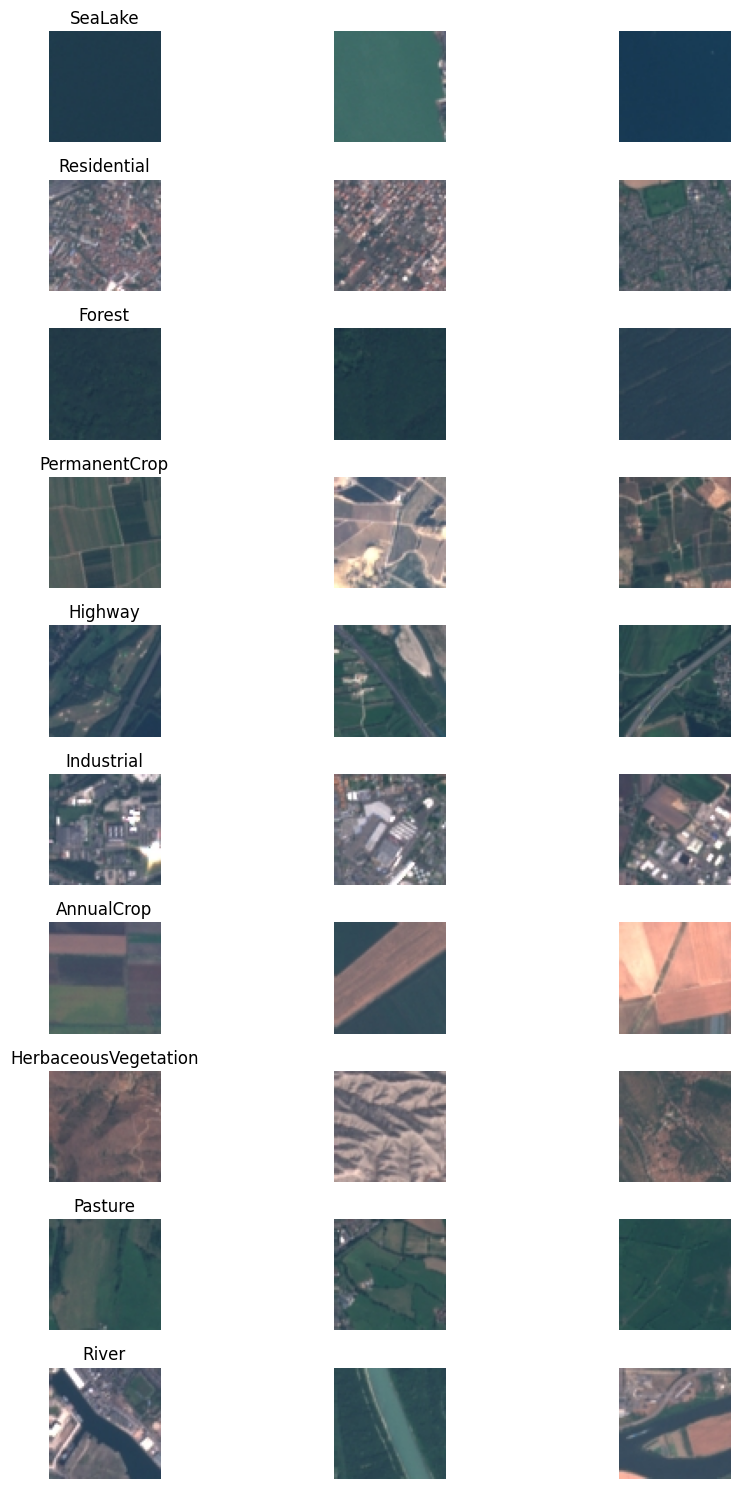

In [ ]:
!pip install opencv-python-headless
import matplotlib.pyplot as plt
import cv2
import random

def show_samples(data_path, classes, samples=3):
    fig, axes = plt.subplots(len(classes), samples, figsize=(10, 15))

    for i, category in enumerate(classes):
        category_path = os.path.join(data_path, category)
        images = random.sample(os.listdir(category_path), samples)

        for j, img_name in enumerate(images):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category)

    plt.tight_layout()
    plt.show()

show_samples(data_path, os.listdir(data_path))


### 📊3 Check Image Dimensions

Now, we check how many images each class has. This tells us whether the dataset is balanced (each class has roughly the same number of images) or imbalanced (some classes dominate).

**👉 Why this is important:**

If a dataset is imbalanced, the model may favor the dominant classes and ignore the smaller ones.

For example, if Forest has 2000 images but River only has 200, the model might always predict Forest — even for rivers!

Imbalanced datasets require techniques like oversampling (increasing smaller classes) or undersampling (reducing larger classes) to prevent bias.

In [ ]:
from PIL import Image

image_sizes = []

for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)
    img_path = os.path.join(category_path, os.listdir(category_path)[0])
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

print("🛠️ Unique image sizes:", set(image_sizes))


🛠️ Unique image sizes: {(64, 64)}


### 📈 4 Class Distribution

Next, let’s check whether all images have the same dimensions (e.g., 64x64 pixels).
Most machine learning models expect consistent input sizes — mismatched dimensions will cause errors.

**👉 Why this is important:**

Different sizes require resizing, which may distort the image if not handled properly.

If sizes vary too much, resizing can lead to loss of detail or squished images — bad for model performance.

<ipython-input-5-fb80ab6ad208>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_class_counts, x="Class", y="Count", palette="viridis")


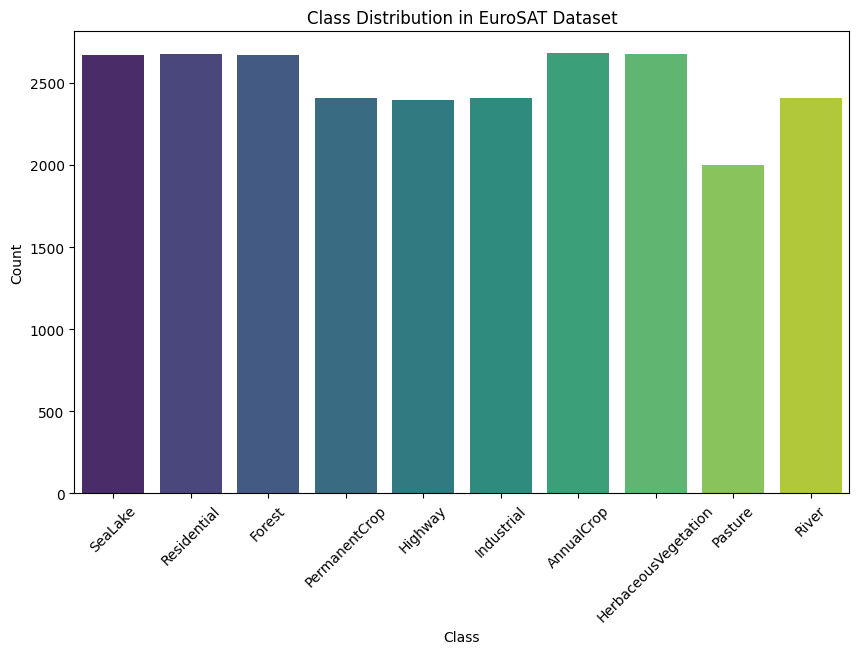

In [ ]:
import pandas as pd
import seaborn as sns

class_counts = {category: len(os.listdir(os.path.join(data_path, category))) for category in os.listdir(data_path)}

df_class_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
plt.figure(figsize=(10, 6))
sns.barplot(data=df_class_counts, x="Class", y="Count", palette="viridis")
plt.xticks(rotation=45)
plt.title("Class Distribution in EuroSAT Dataset")
plt.show()


### 5 Compute Basic Statistics

Each image is made of pixels — and each pixel has intensity values (0 to 255 for RGB images). Analyzing pixel values helps us decide how to normalize the data later.

**👉 Why this is important:**

Neural networks work best with data in a standard range (e.g., 0 to 1 or -1 to 1).

If pixel values vary too widely, the model may take longer to converge or get stuck in poor performance.

In [ ]:
import numpy as np

all_images = []

for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = np.array(Image.open(img_path))
        all_images.append(img)

all_images = np.array(all_images)

print("🔹 Dataset Shape:", all_images.shape)
print("🔹 Pixel Range: Min =", all_images.min(), ", Max =", all_images.max())
print("🔹 Mean Pixel Value:", all_images.mean())
print("🔹 Standard Deviation:", all_images.std())


🔹 Dataset Shape: (24986, 64, 64, 3)
🔹 Pixel Range: Min = 0 , Max = 255
🔹 Mean Pixel Value: 96.42617845811363
🔹 Standard Deviation: 40.39164069602584


### 🎯6. Color Analysis

Calculate the average RGB values per class.

This reveals color patterns — for example, SeaLake may have more blue tones, while Forest has more green.

If classes have distinct color patterns, this is a useful feature!

👉 Bonus insight: If colors overlap a lot, texture or shape might matter more.

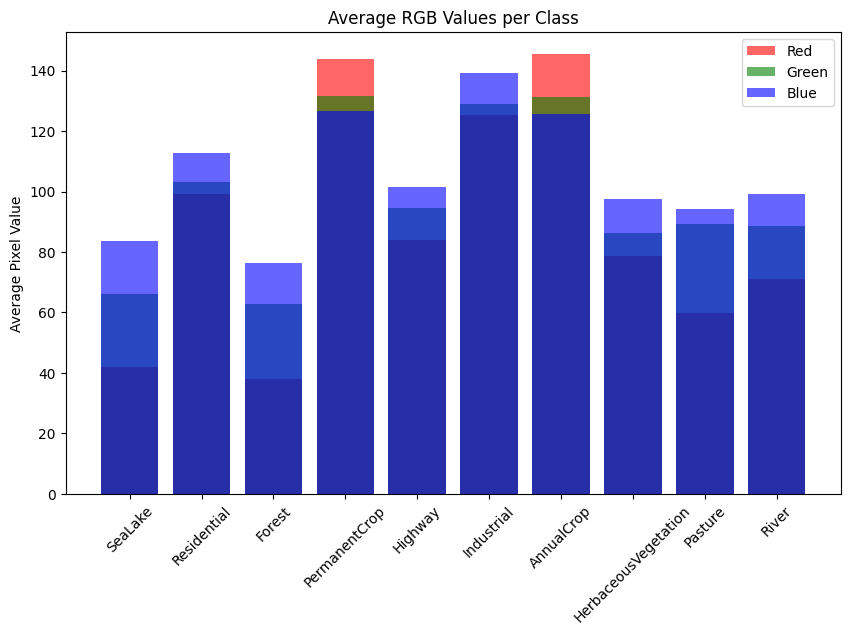

In [ ]:
class_names = os.listdir(data_path)

# Function to calculate average RGB values
def calculate_avg_rgb(image_path):
    img = cv2.imread(image_path)  # Read the image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    return np.mean(img_rgb, axis=(0, 1))  # Calculate mean RGB values

# Store average colors per class
class_colors = {}

for class_name in class_names:
    class_folder = os.path.join(data_path, class_name)
    color_totals = []

    # Go through a few images per class to get average colors
    for i, img_file in enumerate(os.listdir(class_folder)):
        if i >= 10:  # Limit to 10 images per class for speed
            break
        img_path = os.path.join(class_folder, img_file)
        color_totals.append(calculate_avg_rgb(img_path))

    # Get the overall average RGB for this class
    class_colors[class_name] = np.mean(color_totals, axis=0)

# Plotting average RGB values per class
plt.figure(figsize=(10, 6))
for class_name, color in class_colors.items():
    plt.bar(class_name, color[0], color='red', label='Red', alpha=0.6)
    plt.bar(class_name, color[1], color='green', label='Green', alpha=0.6)
    plt.bar(class_name, color[2], color='blue', label='Blue', alpha=0.6)

plt.title("Average RGB Values per Class")
plt.ylabel("Average Pixel Value")
plt.xticks(rotation=45)
plt.legend(["Red", "Green", "Blue"])
plt.show()

### 📌 7. Histogram of Pixel Intensities

Plot a histogram showing pixel intensity distributions across classes.

A wide histogram means varied pixel brightness, while a narrow one indicates similar brightness.

This helps decide whether to apply contrast adjustments or equalization.

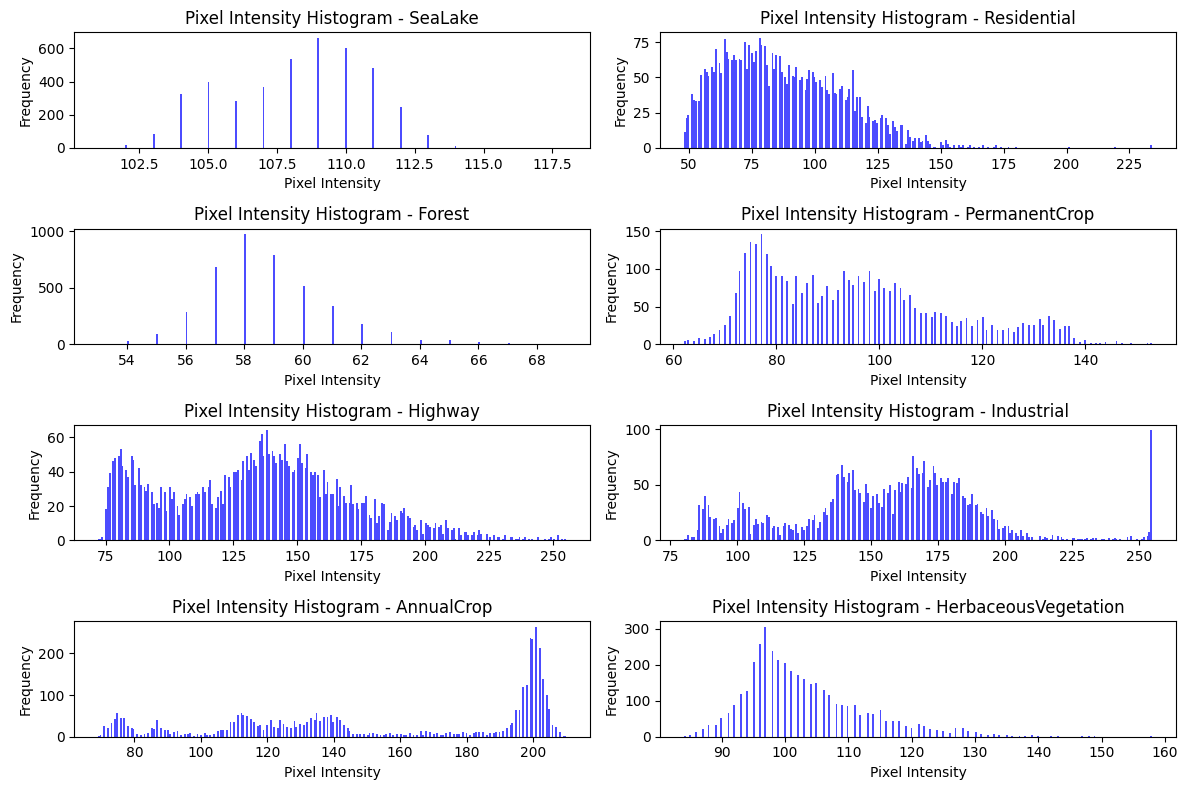

In [ ]:
# Let's pick one sample image from each class for demonstration
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(class_names[:8]):  # Limit to 6 classes for clarity
    class_folder = os.path.join(data_path, class_name)
    sample_image_path = os.path.join(class_folder, os.listdir(class_folder)[0])
    sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

    # Plot histogram for this class's sample image
    plt.subplot(4, 2, i + 1)
    plt.hist(sample_image.ravel(), bins=256, color='blue', alpha=0.7)
    plt.title(f"Pixel Intensity Histogram - {class_name}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(False)

plt.tight_layout()
plt.show()


### 8. Correlation Matrix

If the dataset has multi-band images (e.g., satellite data with extra channels like infrared), check how bands correlate.

A high correlation between bands might indicate redundant information — a sign we could drop some bands without losing much data.

👉 Bonus insight:

If bands are uncorrelated, each band may hold unique, useful info for classification.



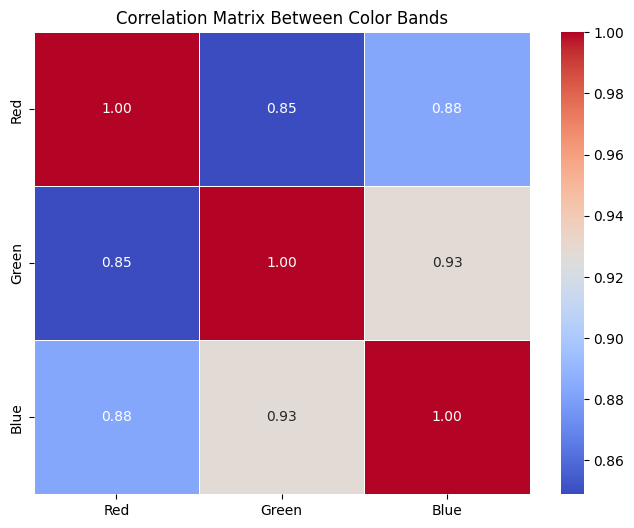

In [ ]:
import pandas as pd
import seaborn as sns

# Let's load one sample multi-band image (if applicable)
# For EuroSAT RGB, we simulate this by stacking R, G, B as bands
sample_image_path = os.path.join(data_path, class_names[0], os.listdir(os.path.join(data_path, class_names[0]))[0])
sample_image = cv2.imread(sample_image_path)
bands = ['Red', 'Green', 'Blue']

# Flatten the image into columns of pixels per band
flattened_bands = [sample_image[:, :, i].flatten() for i in range(3)]

# Create DataFrame for correlation analysis
df_bands = pd.DataFrame(np.array(flattened_bands).T, columns=bands)

# Correlation matrix
correlation_matrix = df_bands.corr()

# Plotting correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Between Color Bands")
plt.show()


## **Data Preprocessing**

Raw data is messy. The idea of preprocessing is to transform the raw dataset into a cleaner, more organized version that’s compatible with Machine Learning models — especially dimensionality reduction techniques like PCA, LDA, SVD, t-SNE, and MDS. Each step serves a specific purpose to ensure the data is in the right shape and scale.

### 🛠️1 Resizing Images

💡 Why resize?

The original EuroSAT dataset contains 64x64 pixel images. This size is decent, but if you’re running heavy algorithms like PCA or SVD, you might want to reduce the size to something smaller, like 32x32 or 28x28.

Smaller images speed up computation without losing too much information.

Ensures uniformity — sometimes datasets may contain images of different sizes (though EuroSAT is clean, resizing is a good habit for other datasets).

🔍 What happens in this step?

Each image is resized to a smaller dimension.

This reduces the total number of pixels (features). For example, 64x64x3 = 12,288 pixels → 32x32x3 = 3,072 pixels.

Each pixel still holds RGB (Red, Green, Blue) information.

👉 Example:
Imagine a satellite image of a field — resizing it makes the file lighter while still keeping enough visual patterns for the model to learn from.



In [ ]:
import cv2

def resize_image(image_path, size=(64, 64)):
    """ Resizes the image to the desired size. """
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, size)
    return img_resized



### 🔧 2 Normalization

💡 Why normalize?

Pixel values range from 0 to 255 (intensity of light).

Machine Learning models (especially ones with gradient descent, like PCA and LDA) perform better when data is within a small range — usually between 0 and 1.

Normalization ensures that no pixel dominates the others.

🔍 What happens in this step?

Each pixel value is divided by 255, converting it to a decimal between 0 and 1.

This also helps prevent exploding gradients — where large numbers cause errors in training.

👉 Example:
A pixel value of 100 (medium gray) becomes 100/255 = 0.39 — now it’s on the same scale as darker pixels like 20/255 = 0.08.



In [ ]:
def normalize_image(image):
    """ Normalizes the image pixel values to 0-1 range. """
    return image / 255.0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image size and batch size
IMG_SIZE = (64, 64)  # Reduce from 256x256 to 64x64 to save memory
BATCH_SIZE = 32

# Use ImageDataGenerator for automatic preprocessing
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Normalize pixel values

# Training Data Generator
# The path is changed to "EuroSAT_Optimized" based on where the data was stored
train_generator = datagen.flow_from_directory(
    'EuroSAT_Optimized',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'  # Change if using a different model output
)

# Validation Data Generator
# The path is changed to "EuroSAT_Optimized" based on where the data was stored
val_generator = datagen.flow_from_directory(
    'EuroSAT_Optimized',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)

Found 19992 images belonging to 10 classes.
Found 4994 images belonging to 10 classes.


###🔍 3 Flatten Images for Dimensionality Reduction

💡 Why flatten?

PCA, LDA, SVD, etc., require the data to be in tabular format — rows and columns, like a spreadsheet.

Each image is originally 3D (Height x Width x Color Channels). Flattening converts it into a 1D vector — just a long line of numbers.
For example:
32x32x3 → 3072 numbers in one row.

Each row becomes a "data point", and the whole dataset becomes a matrix of rows and columns.

🔍 What happens in this step?

The image’s pixel data is unraveled — row by row.

Each pixel’s three color channels (RGB) follow one another.

In [ ]:
import numpy as np

def flatten_image(image):
    """ Flattens the image into a single 1D vector. """
    return image.flatten()


###🧹 4 Convert Dataset to Matrix Format

💡 Why convert to a matrix?

All dimensionality reduction algorithms need data as a 2D matrix — rows (data points) and columns (features).

Each row represents one image (flattened).

Each column is a pixel’s value — a feature.

🔍 What happens in this step?

We combine all images into one giant matrix (num_images x num_features).
Example: If you have 10,000 images, each 32x32x3 (3072 features), the matrix looks like:
(10000, 3072) — 10,000 rows and 3,072 columns.

Labels (e.g., 'Forest', 'River', 'Industrial') are stored separately for classification models later.


In [ ]:
image_data = []
labels = []

for class_name in class_names:
    class_folder = os.path.join(data_path, class_name)
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        img_resized = resize_image(img_path)
        img_normalized = normalize_image(img_resized)
        img_flattened = flatten_image(img_normalized)

        image_data.append(img_flattened)
        labels.append(class_name)

# Convert to NumPy array for easier processing
image_data = np.array(image_data)
labels = np.array(labels)

print("✅ Data shape:", image_data.shape)
print("✅ Labels shape:", labels.shape)



✅ Data shape: (24986, 12288)
✅ Labels shape: (24986,)


## **Dimensionality reduction techniques**




1️⃣ PCA Implementation

2️⃣ LDA Implementation

3️⃣ SVD Implementation

4️⃣ t-SNE Implementation

5️⃣ MDS Implementation

6️⃣ Comparative Analysis of Model Performance

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path

def preprocess_images(data_path, target_size=(32, 32)):  # Reduce from 64x64 to 32x32
    images = []
    # Get all image paths recursively within the data_path directory
    image_paths = list(Path(data_path).rglob("*.jpg"))
    for img_path in image_paths:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = cv2.resize(img, target_size)  # Resize
        images.append(img.flatten())  # Flatten the image
    return np.array(images)

X = preprocess_images(data_path)  # Apply this before PCA, LDA, etc.

PCA Accuracy: 0.6282513005202081
              precision    recall  f1-score   support

           0       0.52      0.55      0.53       513
           1       0.84      0.90      0.87       527
           2       0.52      0.51      0.51       522
           3       0.40      0.16      0.23       497
           4       0.73      0.87      0.80       504
           5       0.70      0.78      0.74       390
           6       0.54      0.37      0.44       516
           7       0.52      0.76      0.62       558
           8       0.49      0.56      0.52       438
           9       0.94      0.81      0.87       533

    accuracy                           0.63      4998
   macro avg       0.62      0.63      0.61      4998
weighted avg       0.62      0.63      0.61      4998

LDA Accuracy: 0.24749899959983993
              precision    recall  f1-score   support

           0       0.25      0.29      0.27       513
           1       0.38      0.33      0.36       527
           

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


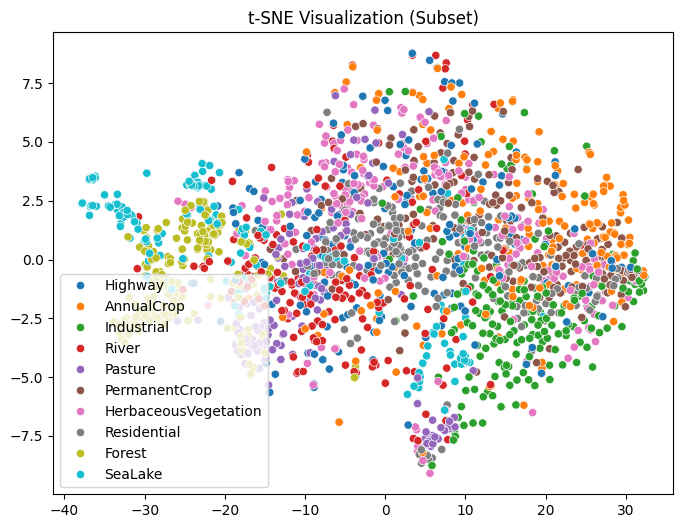

SVD Accuracy: 0.618047218887555
              precision    recall  f1-score   support

           0       0.49      0.56      0.52       513
           1       0.85      0.89      0.87       527
           2       0.48      0.51      0.50       522
           3       0.43      0.18      0.26       497
           4       0.71      0.79      0.75       504
           5       0.67      0.76      0.71       390
           6       0.48      0.39      0.43       516
           7       0.58      0.69      0.63       558
           8       0.49      0.61      0.54       438
           9       0.94      0.80      0.87       533

    accuracy                           0.62      4998
   macro avg       0.61      0.62      0.61      4998
weighted avg       0.61      0.62      0.61      4998



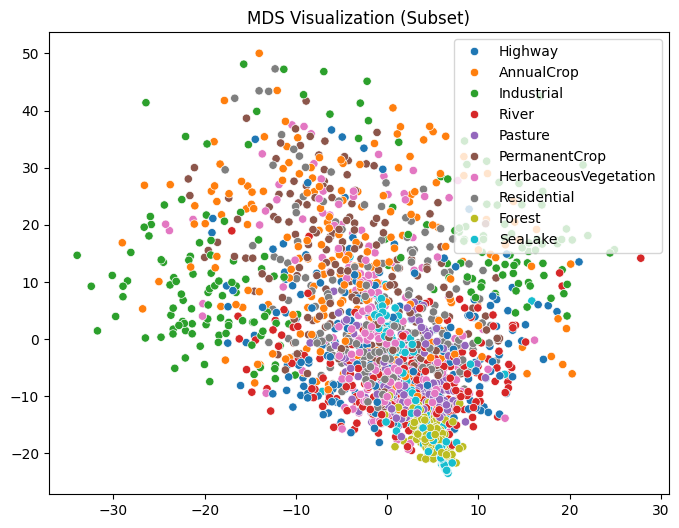

5138

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import gc  # Garbage collection to manage memory

# Assuming 'image_data' and 'labels' are already defined from previous cells

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42)

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# --- Optimized PCA ---
sample_size_pca = min(5000, X_train.shape[0])  # Adjust sample size
X_train_pca_sample, y_train_pca_sample = shuffle(X_train, y_train_encoded, random_state=42, n_samples=sample_size_pca)
optimal_pca_components = min(30, X_train_pca_sample.shape[1])  # Dynamically reduce dimensions
pca = PCA(n_components=optimal_pca_components, svd_solver='randomized')
X_train_pca = pca.fit_transform(X_train_pca_sample)
X_test_pca = pca.transform(X_test)

clf_pca = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=2)  # Limit n_jobs
clf_pca.fit(X_train_pca, y_train_pca_sample)  # Use y_train_pca_sample
y_pred_pca = clf_pca.predict(X_test_pca)
print("PCA Accuracy:", accuracy_score(y_test_encoded, y_pred_pca))
print(classification_report(y_test_encoded, y_pred_pca))

# Clean up PCA variables to free memory
del X_train_pca, X_test_pca
gc.collect()

# --- Optimized LDA ---
sample_size_lda = min(5000, X_train.shape[0])
X_train_lda_sample, y_train_lda_sample = shuffle(X_train, y_train_encoded, random_state=42, n_samples=sample_size_lda)
lda_components = min(len(np.unique(y_train)) - 1, X_train_lda_sample.shape[1])
lda = LDA(n_components=lda_components)
X_train_lda = lda.fit_transform(X_train_lda_sample, y_train_lda_sample)
X_test_lda = lda.transform(X_test)

clf_lda = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=2)  # Limit n_jobs
clf_lda.fit(X_train_lda, y_train_lda_sample)  # Use the sampled target variable
y_pred_lda = clf_lda.predict(X_test_lda)
print("LDA Accuracy:", accuracy_score(y_test_encoded, y_pred_lda))
print(classification_report(y_test_encoded, y_pred_lda))

# Clean up LDA variables to free memory
del X_train_lda, X_test_lda
gc.collect()

# --- Optimized t-SNE ---
subset_size_tsne = 2000  # Reduce sample size for visualization
X_train_subset, y_train_subset = shuffle(X_train, y_train, random_state=42, n_samples=subset_size_tsne)

tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_subset)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_tsne[:,0], y=X_train_tsne[:,1], hue=y_train_subset, palette='tab10')
plt.title("t-SNE Visualization (Subset)")
plt.show()

# Clean up t-SNE variables to free memory
del X_train_tsne, X_train_subset
gc.collect()

# --- Optimized SVD ---
sample_size_svd = min(5000, X_train.shape[0])
X_train_svd_sample, y_train_svd_sample = shuffle(X_train, y_train_encoded, random_state=42, n_samples=sample_size_svd)
optimal_svd_components = min(30, X_train_svd_sample.shape[1])
svd = TruncatedSVD(n_components=optimal_svd_components, algorithm='randomized')
X_train_svd = svd.fit_transform(X_train_svd_sample)
X_test_svd = svd.transform(X_test)

clf_svd = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=2)  # Limit n_jobs
clf_svd.fit(X_train_svd, y_train_svd_sample)  # Use the sampled target variable
y_pred_svd = clf_svd.predict(X_test_svd)
print("SVD Accuracy:", accuracy_score(y_test_encoded, y_pred_svd))
print(classification_report(y_test_encoded, y_pred_svd))

# Clean up SVD variables to free memory
del X_train_svd, X_test_svd
gc.collect()

# --- Optimized MDS ---
mds_subset_size = 2000
X_train_mds_subset, y_train_mds_subset = shuffle(X_train, y_train, random_state=42, n_samples=mds_subset_size)

mds = MDS(n_components=2, n_jobs=-1, random_state=42)
X_train_mds = mds.fit_transform(X_train_mds_subset)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_mds[:,0], y=X_train_mds[:,1], hue=y_train_mds_subset, palette='tab10')
plt.title("MDS Visualization (Subset)")
plt.show()

# Clean up MDS variables to free memory
del X_train_mds
gc.collect()

# Optionally, delete other large variables if needed
del X_train, X_test, y_train, y_test, y_train_encoded, y_test_encoded
gc.collect()


### **🎯 Algorithm Overview**
1️⃣ PCA (Principal Component Analysis)

PCA reduces dimensionality by projecting data onto a lower-dimensional space while preserving maximum variance.

It computes eigenvectors and eigenvalues of the covariance matrix to determine principal components (directions of maximum variance).

It’s effective for continuous, large datasets where reducing features can speed up training.

2️⃣ LDA (Linear Discriminant Analysis)

LDA is a supervised algorithm that maximizes class separability.

It projects data onto a new axis that maximizes the distance between different class means while minimizing the variance within each class.

It’s more effective when the target variable has clear class distinctions.

3️⃣ SVD (Singular Value Decomposition)

SVD decomposes data into three matrices: U, Σ, and V.

It captures dominant patterns in data — useful for noise reduction, compression, or image data (like EuroSAT).

4️⃣ t-SNE (T-Distributed Stochastic Neighbor Embedding)

t-SNE converts high-dimensional data into a low-dimensional map, maintaining local data structure.

It’s primarily used for visualization rather than classification due to its stochastic nature and slower performance on large datasets.

5️⃣ MDS (Multidimensional Scaling)

MDS seeks to place data points in a low-dimensional space while maintaining the original distances between points.

It’s useful when you care about preserving pairwise distances (e.g., satellite image categories with spatial similarities).


### **🔥 Final Conclusion**
PCA gives a general reduction but may lose class information. It’s great when variance is key.

LDA performs well when class labels guide reduction, often outperforming PCA in classification.

SVD is efficient with large, noisy datasets but lacks interpretability compared to PCA/LDA.

t-SNE and MDS are invaluable for spotting structure in complex data, but unsuitable for classification pipelines.

Best Approach?

**For EuroSAT, LDA likely outshines PCA and SVD due to clear land use classes.
t-SNE/MDS shine in showing data clusters visually, aiding insights into misclassifications or dataset bias.**